<a href="https://colab.research.google.com/github/elhamod/BA820/blob/main/Hands-on%20/03-dimensionality-reduction/Dim_reduction_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Course: BA820 - Unsupervised and Unstructured ML**

**Notebook created by: Mohannad Elhamod**

Let's use the MNIST dataset (hand-written digits) to appreicate how powerful dimensionality reduction can be.

##Load the data

In [ ]:
# !pip install joblib

In [ ]:
from sklearn.datasets import fetch_openml
from joblib import Memory

# fetch and cache the dataset
mem = Memory('./tmp')
fetch_openml_cached = mem.cache(fetch_openml)
mnist = fetch_openml_cached(name='mnist_784')


In [ ]:
data, label = mnist["data"], mnist["target"]

data.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.197414,0.099543,0.046629,0.016614,0.012957,0.001714,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.991206,4.256304,2.783732,1.561822,1.553796,0.320889,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


##Data Preprocessing

Let's normalize the data

In [ ]:
data = data/255

Let's get a subset of the dataset. Only 0s and 1s.

In [ ]:
# get a subset of digits
label = label.astype(int)

# Filter the dataset to contain only the digits '0' and '1'
digits = [0, 1]
valid_indices = label.isin(digits)
data = data[valid_indices]
label = label[valid_indices]
data.shape

(14780, 784)

It is still a lot of data. Let's do some sampling using `StratifiedShuffleSplit`

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# get 1000 images
splitter = StratifiedShuffleSplit(n_splits=1, test_size=1000)

_, sampled_indices = next(splitter.split(data, label))
data_sampled = data.iloc[sampled_indices]
label_sampled = label.iloc[sampled_indices]

How many images of each label is there?

In [ ]:
label_sampled.value_counts()

,count
class,
1,533
0,467


##Clustering

Let's use K-means

In [ ]:
from sklearn.cluster import KMeans


# Find clusters
k = len(digits) #4
kmeans_result = KMeans(n_clusters=k, random_state=0).fit(data_sampled)

data_sampled_labeled = data_sampled.copy()
data_sampled_labeled['cluster_labels'] = kmeans_result.labels_

Let's look at the centroids

In [ ]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

for i in range(kmeans_result.cluster_centers_.shape[0]): # for each centroid
  display(Image.fromarray(np.reshape(kmeans_result.cluster_centers_[i]*255,(28,28))).convert("L")) # Convert numpy array to an image
  clust_representative = label_sampled[kmeans_result.labels_ == i].mode().iloc[0] # Get the supervised label of the image
  print('label', clust_representative, '\n')

label 1 



label 0 



**Question:** Is the cluster's centroid a real image (i.e., an existing data point)?

Let's check how the true label and the cluster label relate to each other.

In [ ]:
!pip install psynlig

In [ ]:
corr_df = data_sampled_labeled[["cluster_labels"]]
corr_df['true_labels'] = label_sampled

from sklearn.metrics import confusion_matrix
import pandas as pd

conf_matrix = confusion_matrix(corr_df['true_labels'], corr_df['cluster_labels'], normalize='true')

# Convert to DataFrame for better readability
conf_matrix_df = pd.DataFrame(conf_matrix,
                              index=['true_labels 0', 'true_labels 1'],
                              columns=['cluster_labels 0', 'cluster_labels 1'])
conf_matrix_df

/tmp/ipykernel_27405/1935641173.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_df['true_labels'] = label_sampled


,cluster_labels 0,cluster_labels 1
true_labels 0,0.023555,0.976445
true_labels 1,1.000000,0.000000


**Question:** It seems the zeros are in cluster 1 and vice versa. This is horrible, no? Explain...

### Determining Optimal Clustering

How about trying different k values for clustering and use the elbow method

In [ ]:
!pip install yellowbrick

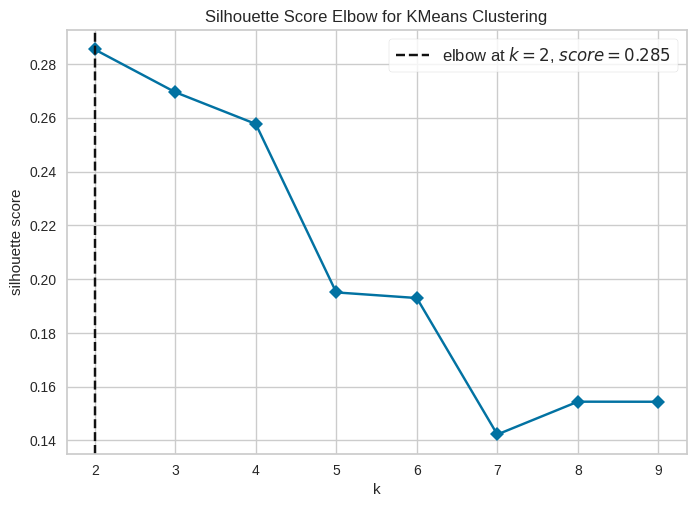

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans()
visualizer = KElbowVisualizer(
    kmeans, k=(2,10), metric='silhouette', timings=False #metric='silhouette' metric='distortion'
)

visualizer.fit(data_sampled)        # Fit the data to the visualizer
visualizer.show()

## Dimensionality Reduction: PCA

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd

# Create the model
model = PCA(3)

#fit the data
model.fit(data_sampled)
transformed_data = model.transform(data_sampled)

# transform the data
transformed_data_df = pd.DataFrame(transformed_data, columns = ['PC1', 'PC2', 'PC3'])
transformed_data_df['cluster_labels'] = data_sampled_labeled['cluster_labels'].values

transformed_data_df

,PC1,PC2,PC3,cluster_labels
0,-4.027418,-4.616449,2.242060,1
1,-0.629268,-2.300352,1.826158,1
2,-6.238668,0.890708,0.070192,1
3,-4.739940,1.296963,-0.964498,1
4,-2.999091,1.428755,-1.866415,1
...,...,...,...,...
995,3.483746,-0.344867,-1.628459,0
996,-3.280527,-3.275706,1.520926,1
997,-3.769274,-2.004692,1.933597,1
998,-6.613360,-2.065270,1.218400,1


How many images are their in each cluster? any thoughts?

In [ ]:
transformed_data_df['cluster_labels'].value_counts()

,count
cluster_labels,
0,544
1,456


Let's plot the cluster in the new space

In [ ]:
import plotly.express as px

fig = px.scatter_3d(transformed_data_df, x='PC1', y='PC2', z='PC3', color = 'cluster_labels')
fig.update_traces(marker_size = 3) # makes the points smaller (better visualization)
fig.show()

Let's plot an original image and a reconstructed one

In [ ]:
reconstruced_data = model.inverse_transform(transformed_data_df.drop('cluster_labels', axis=1))
reconstruced_data_df = pd.DataFrame(reconstruced_data)

In [ ]:
reconstruced_data.shape

(1000, 784)

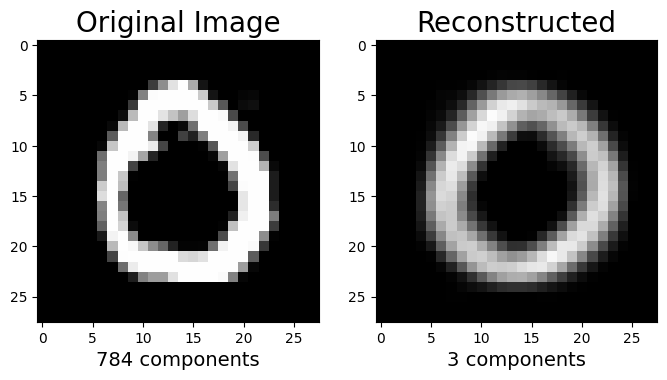

In [ ]:
plt.figure(figsize=(8,4));
img_index = 555

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(data_sampled.to_numpy()[img_index,:].reshape(28,28)*255,
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('784 components', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 3 principal components
plt.subplot(1, 2, 2);
plt.imshow(reconstruced_data_df.to_numpy()[img_index, :].reshape(28, 28)*255,
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel(str(model.n_components_) + ' components', fontsize = 14)
plt.title('Reconstructed', fontsize = 20);

###Traversing along PC1

What does traversing PC1 look like?

In [ ]:
components_df = pd.DataFrame(model.components_, index=['PC1', 'PC2', 'PC3'])
components_df

loadings = components_df.mul(np.sqrt(model.explained_variance_), axis=0)

loadings_df = pd.DataFrame(loadings, index=['PC1', 'PC2', 'PC3'])
loadings_df

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
PC1,4.188181e-21,-1.172990e-21,-1.748242e-23,8.769693e-24,1.221551e-24,-6.738416e-26,4.352412e-26,-5.629388e-28,1.210355e-27,2.834909e-27,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
PC2,4.338808e-17,-1.042400e-17,4.222696e-19,6.303141e-21,3.852252e-21,-4.931062e-21,1.407256e-21,-1.307633e-22,-2.290839e-23,-3.548740e-24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PC3,-3.097037e-17,9.086969e-18,3.872143e-19,2.471409e-21,-9.433586e-21,4.180273e-21,-1.159914e-21,1.443363e-22,7.492313e-23,6.264497e-23,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


Let's find the variance along PC1 and then traverse from -3 standard deviations to +3 standard deviations.

In [ ]:
loadings_df.T.describe()

,PC1,PC2,PC3
count,784.000000,784.000000,7.840000e+02
mean,-0.052438,-0.008980,-1.049474e-04
std,0.131713,0.075629,7.199689e-02
min,-0.360924,-0.220425,-1.917029e-01
25%,-0.111938,-0.022190,-1.204847e-02
50%,-0.000298,0.000000,-0.000000e+00
75%,0.000000,0.001333,2.562153e-18
max,0.455297,0.239503,3.054184e-01


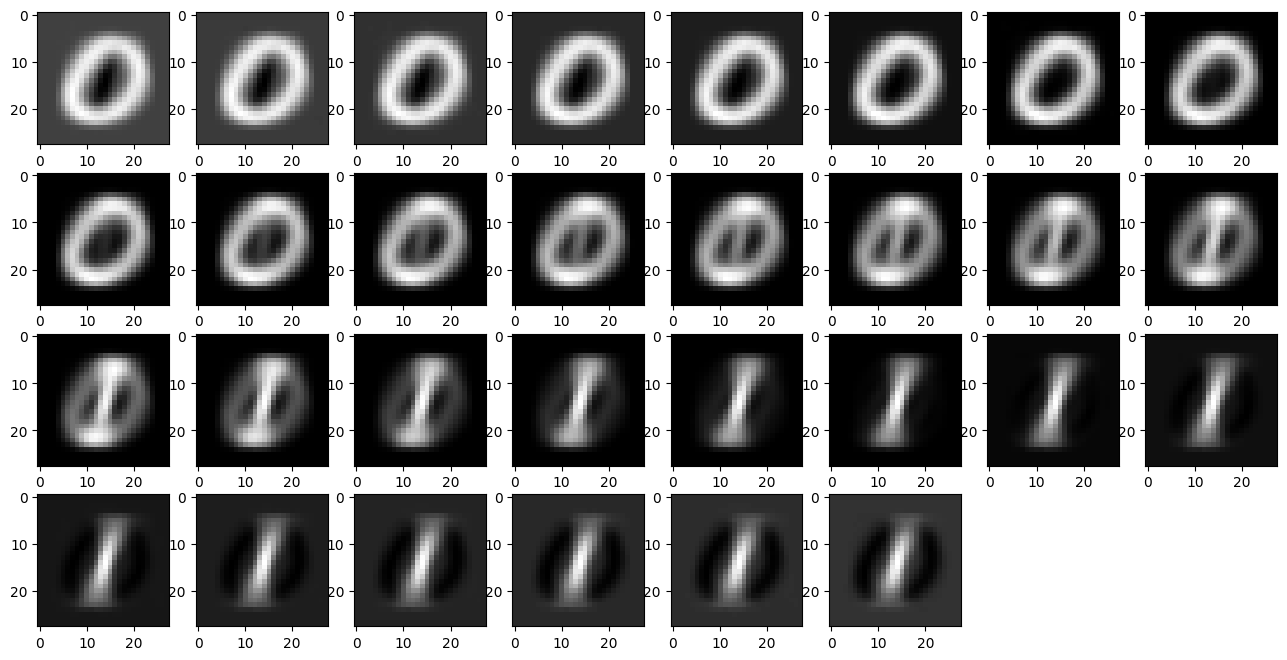

In [ ]:
plt.figure(figsize=(16,8));
from PIL import Image

num_of_intermediate_steps_to_display = 30
scale = 0.5 # should be around 3 sigmas

# Get a PCA model with one component
model_onecomponent = PCA(n_components=1)
model_onecomponent.fit(data_sampled)

for i in np.arange(-int(num_of_intermediate_steps_to_display/2), int(num_of_intermediate_steps_to_display/2), 1): #for num_of_intermediate_steps_to_display steps
  reconstruction = model_onecomponent.inverse_transform([[i*scale]]) # reconstruct. Make sure the dimensions of the matrix make sense!

  # plot the digit
  plt.subplot(4, int(num_of_intermediate_steps_to_display/4 + 1), i+int(num_of_intermediate_steps_to_display/2)+1);
  plt.imshow(reconstruction.reshape(28, 28)*255,
              cmap = plt.cm.gray, interpolation='nearest');

###Scree plot

In [ ]:
!pip install psynlig

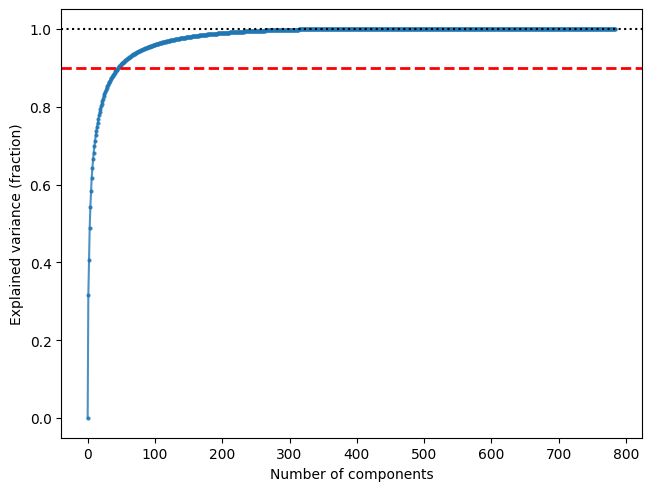

In [ ]:
from matplotlib import pyplot as plt
from psynlig import (
    pca_explained_variance,
    pca_explained_variance_bar,
)

model_all_dims = PCA()
model_all_dims.fit(data_sampled)

_, ax = pca_explained_variance(model_all_dims,   marker='o', markersize=2, alpha=0.8)

# Let's add a line at an explained variance of 90%
ax.axhline(y=0.9, color='r', linestyle='--', linewidth=2)

plt.show()


##Questions

1. What happens to the cluster centriods if there are too few images.
2. Sample two extreme points along PC2 and see what they look like...
3. Try different digits.
4. What would the results look like if we keep all digits, noit just 0s and 1s? What would be the meaning of PC1 in that case?